In [1]:
from typing import Optional

import numpy as np
import scipy.linalg
import scipy.special
import scipy.stats
import sklearn
from numpy.typing import ArrayLike
from collections import defaultdict
from sklearn.utils.validation import check_is_fitted
from sklearn.exceptions import NotFittedError
from copy import deepcopy
import time
from tqdm import tqdm

from sktree.ensemble import UnsupervisedObliqueRandomForest, UnsupervisedRandomForest
from sktree.tree import compute_forest_similarity_matrix
import random
import matplotlib.pyplot as plt

# G-KSG
Use Unsupervised Random Forests to estimate MI
### Steps
1. Train a forest with joint dataset (Z = (X, Y)) get d_xy 
        - get d_z: k-th closest d_xy
2. Train 2 forests with marginals dataset (X, Y)
3. get geodesic distance d_x, and d_y from 2 
        - get 
4. calculate MI from d_x, d_y, d_xy as  

$\Psi(k) - E[(\Psi(n_x) + \Psi(n_y))] + \Psi(n)$


In [135]:
n = 700
px = py = 1
k = 1
alpha = 0.01
n_estimators = 100
max_features = 0.3
max_depth = None
min_samples_leaf = 2
X = np.random.uniform(0, 1, size=(n,px))
N = np.random.uniform(-alpha/2, alpha/2, size=(n,px))
Y = X + N
Z = np.hstack([X, Y])
n = X.shape[0]
px = X.shape[1]
py = Y.shape[1]
assert X.shape[0] == Y.shape[0]
null_x = np.zeros(shape=(n, py))
null_y = np.zeros(shape=(n, px))
X0 = np.hstack([X, null_x])
Y0 = np.hstack([Y, null_y])
estimator_X = UnsupervisedRandomForest(n_estimators=n_estimators, max_features=max_features, min_samples_leaf=min_samples_leaf)
estimator_Y = UnsupervisedRandomForest(n_estimators=n_estimators, max_features=max_features, min_samples_leaf=min_samples_leaf)
estimator_X.fit(X0)
estimator_Y.fit(Y0)
d_x = 1-estimator_X.compute_similarity_matrix(Z)
d_y = 1-estimator_Y.compute_similarity_matrix(Z)
d_z = np.maximum(d_x, d_y)
# if d_z = 0, then get L2 norm
for i in range(n):
    for j in range(n):
        if (d_z[i, j]==0.0) and (i != j):
            d_z[i, j] = np.linalg.norm(Z[i, :] - Z[j, :])/n_estimators
n_x = []
n_y = []
for sample_id in range(n):
    d_zik = np.sort(d_z[sample_id])[k]
    n_xi = np.sum(np.array(d_x[sample_id] < d_zik)) -1 # for itself
    n_x.append(n_xi)
    n_yi = np.sum(np.array(d_y[sample_id] < d_zik)) -1 # for itself
    n_y.append(n_yi)

mi = ksg_mi(k,n,np.array(n_x), np.array(n_y), verbose=True)
print(mi)
true_mi = alpha/2 - np.log(alpha)
print("true_mi = ", true_mi)



MI =  4.465020319672863
MI = hk - E[hx + hy] + hn = -0.5772156649015329 - (0.6113557636698957 + 0.8967741310168345) + 6.550365879261126
4.465020319672863
true_mi =  4.610170185988091


In [13]:


class G_KSG_MI_Estimator:
    def __init__(self, k: int = 1, n_estimators: int = 100, max_features: float = 1.0, max_depth: Optional[int] = None, min_samples_leaf: int = 2):
        self.k = k
        self.n = None
        self.n_estimators = n_estimators
        self.n_x = None
        self.n_y = None
        self.max_features = max_features
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.p = None
        self.estimator_X = UnsupervisedRandomForest(n_estimators=self.n_estimators, max_features=self.max_features, min_samples_leaf=self.min_samples_leaf)
        self.estimator_Y = UnsupervisedRandomForest(n_estimators=self.n_estimators, max_features=self.max_features, min_samples_leaf=self.min_samples_leaf)
    
    def fit(self, X, Y):
        # joint space Z = [X, Y]
        Z = np.hstack([X, Y])
        self.n = X.shape[0]
        self.px = X.shape[1]
        self.py = Y.shape[1]
        assert X.shape[0] == Y.shape[0]
        # Z = np.hstack([X, Y])
        null_x = np.zeros(shape=(self.n, self.py))
        null_y = np.zeros(shape=(self.n, self.px))
        X0 = np.hstack([X, null_x])
        Y0 = np.hstack([Y, null_y])
        self.estimator_X.fit(X0)
        self.estimator_Y.fit(Y0)
        self.d_x = 1-self.estimator_X.compute_similarity_matrix(Z)
        self.d_y = 1-self.estimator_Y.compute_similarity_matrix(Z)
        self.d_z = np.maximum(self.d_x, self.d_y)
        # if d_z = 0, then get L2 norm
        for i in range(self.n):
            for j in range(self.n):
                if (self.d_z[i, j]==0.0) and (i != j):
                    self.d_z[i, j] = np.linalg.norm(Z[i, :] - Z[j, :])/self.n_estimators

        self.n_x = []
        self.n_y = []
        for sample_id in range(n):
            d_zik = np.sort(self.d_z[sample_id])[k]
            n_xi = np.sum(np.array(self.d_x[sample_id] < d_zik)) -1 # remove itself
            self.n_x.append(n_xi)
            n_yi = np.sum(np.array(self.d_y[sample_id] < d_zik)) -1 # remove itself
            self.n_y.append(n_yi)
        return self
    
    def ksg_mi(self, X, Y, verbose: bool = False):
        self.fit(X, Y)
        k = self.k
        n = self.n
        n_x = np.array(self.n_x)
        n_y = np.array(self.n_y)
        # compute the MI using the KSG estimator
        # \\psi(k) - E[(\\psi(n_x) + \\psi(n_y))] + \\psi(n)
        hk = scipy.special.digamma(k)
        hx = scipy.special.digamma(n_x +1)
        hy = scipy.special.digamma(n_y +1)
        hn = scipy.special.digamma(n)
        mi = hk - (hx + hy).mean() + hn
        if verbose:
            print("MI = ", mi)
            print(f"MI = hk - E[hx + hy] + hn = {hk} - ({hx.mean()} + {hy.mean()}) + {hn}")
        return mi

n = 1000
px = py = 1
k = 1
alpha = 0.01
n_estimators = 100
max_features = 0.3
max_depth = None
min_samples_leaf = 2
X = np.random.uniform(0, 1, size=(n,px))
N = np.random.uniform(-alpha/2, alpha/2, size=(n,px))
Y = X + N

estimator = G_KSG_MI_Estimator(k=k, n_estimators=n_estimators, max_features=max_features, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
mi = estimator.ksg_mi(X, Y, verbose=False)
print("mi = ",mi)
true_mi = alpha/2 - np.log(alpha)
print("true_mi = ", true_mi)


mi =  4.79013514626463
true_mi =  4.610170185988091


## Experiment

$X = Unif(0, 1)$  
$Y = X + Unif(-\alpha/2, \alpha/2)$  
$I(X; Y) = h(Y)-h(Z)= \alpha/2 - \log(\alpha)$



100%|██████████| 5/5 [04:42<00:00, 56.47s/it]

[2.7473775176396207, 3.32469761478811, 4.127156763323857, 4.784230384359869, 5.449758778213457]


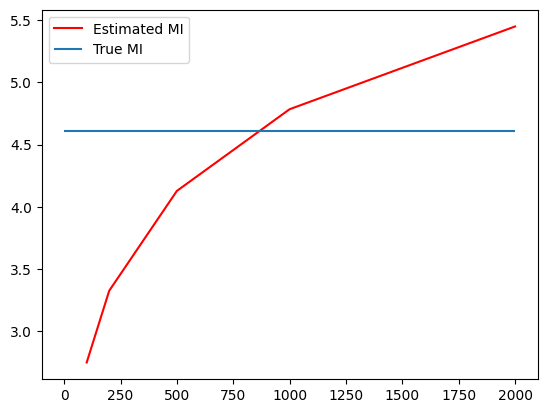

In [14]:
num_samples = [100, 200, 500, 1000, 2000]
px = py = 1
k = 1
alpha = 0.01
n_estimators = 100
max_features = 0.3
max_depth = None
min_samples_leaf = 2
num_trials = 1
results = []
times = []
for n in tqdm(num_samples):
    t0 = time.time()
    _res = []
    for _ in tqdm(range(num_trials)):
        X = np.random.uniform(0, 1, size=(n,px))
        N = np.random.uniform(-alpha/2, alpha/2, size=(n,px))
        Y = X + N
        estimator = G_KSG_MI_Estimator(k=k, n_estimators=n_estimators, max_features=max_features, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        mi = estimator.ksg_mi(X, Y, verbose=False)
        _res.append(mi)
    times.append(time.time() - t0)
    results.append(np.mean(_res))
    print(results[-1])

# calulate the true MI 
true_mi = alpha/2 - np.log(alpha)
print(results)
plt.plot(num_samples, results, label="Estimated MI", c="red")
plt.hlines(true_mi, xmin=0, xmax=num_samples[-1], label="True MI")
plt.legend()